In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
import sklearn.preprocessing
from matplotlib import pyplot as plt
%matplotlib inline
# from hw2 import *

## Copied from hw3.py (external file)

In [3]:
mnist = fetch_mldata('MNIST original')
data = mnist['data']
labels = mnist['target']

train_idx = np.random.RandomState(0).permutation(range(60000))

train_data_size = 50000
train_data_unscaled = data[train_idx[:train_data_size], :].astype(float)
train_labels = labels[train_idx[:train_data_size]]

validation_data_unscaled = data[train_idx[train_data_size:60000], :].astype(float)
validation_labels = labels[train_idx[train_data_size:60000]]

test_data_unscaled = data[60000:, :].astype(float)
test_labels = labels[60000:]

# Preprocessing
train_data = sklearn.preprocessing.scale(train_data_unscaled, axis=0, with_std=False)
validation_data = sklearn.preprocessing.scale(validation_data_unscaled, axis=0, with_std=False)
test_data = sklearn.preprocessing.scale(test_data_unscaled, axis=0, with_std=False)

In [4]:
train_data.shape, validation_data.shape, test_data.shape

((50000L, 784L), (10000L, 784L), (10000L, 784L))

In [5]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

## Linear Multiclass SVM

### (a) implement the SGD_no_kernel algorithm

In [305]:
def sgd_no_kernel(train_data, train_labels,eta = 0.1, C=1,T=100000):
    '''implements SGD_no_kernel algorithm on training set and returns the W matrix'''
    w= numpy.zeros(shape = (len(np.unique(train_labels)),train_data.shape[1])) # initiate weights vectors to zeros
    for t in range(T):
        ind = np.random.randint(len(train_data))# randomly pick one sample
        sample, sample_label= train_data[ind], train_labels[ind] 
        j_max = -9999999
        j_max_ind = 0
        for j in range(len(w)): # check and update for each j the weights
            err = np.dot(w[j],sample) - np.dot(w[sample_label],sample) + int(sample_label != j)
            if j_max < err:
                j_max = err
                j_max_ind = j
            w[j] = (1-eta)*w[j]
        if j_max_ind != sample_label:
            w[j_max_ind] -= eta*C*sample #update using the derivative when j == yi
            w[sample_label] += eta*C*sample #update using the derivative
    return w   

In [306]:
def predict(w, sample):
    ''' returns the prediction label'''
    w_best_ind = -1
    best = -999999
    for j in range(len(w)):
        pred = np.dot(w[j], sample)
        if pred >= best:
            w_best_ind = j
            best = pred
    return w_best_ind

In [307]:
def get_accuracy(w, validation_data, validation_labels):
    '''returns accuracy on the validation or test data, given the classifier weights'''
    err= 0
    for i in range(len(validation_data)):
        pred_ind = predict(w, validation_data[i])
        if pred_ind != validation_labels[i]: # error in the prediction
            err = err+1
    return 1-1.0*err/len(validation_data)

Find the best $\eta$ and C, using coordinate search  
Can be imagined as if $\eta$ and C are two coordinates

In [308]:
def sgd_and_acc(train_data, train_labels, validation_data, validation_labels, eta=0.1, C=1, T=100000):
    w = sgd_no_kernel(train_data, train_labels, eta=eta,C=C, T=T)
    return get_accuracy(w,validation_data, validation_labels), get_accuracy(w,train_data, train_labels)

In [309]:
def q6_a_grid_search(train_data, train_labels, validation_data, validation_labels):
    eta_values = np.power(2.0,-1.0*np.arange(-4,30,4))
    C_values = np.power(2.0,-1.0*np.arange(-4,30,4))
    val_err_eta,train_err_eta = [], []
    val_err_C, train_err_C = [], []
    for eta in eta_values:
        acc_val, acc_train = sgd_and_acc(train_data, train_labels, validation_data, validation_labels, eta=eta, C=0.5, T=100000)
        val_err_eta.append(1.0-acc_val)
        train_err_eta.append(1.0-acc_train)
    best_eta = list(eta_values)[val_err_eta.index(min(val_err_eta))]
    print 'q6_a: best eta', best_eta
    for C in C_values:
        acc_val, acc_train = sgd_and_acc(train_data, train_labels, validation_data, validation_labels, eta=best_eta, C=C, T=100000)
        val_err_C.append(1.0-acc_val)
        train_err_C.append(1.0-acc_train)    
    best_C = list(C_values)[val_err_C.index(min(val_err_C))]
    print 'q6_a: best C', best_C
    return best_eta, best_C, eta_values, C_values,val_err_eta, train_err_eta,val_err_C , train_err_C

In [310]:
def q6_a_plot_param_err(value_range, err_train, err_val, param_name = 'Eta'):
    plt.figure()
    plt.plot(np.log2(value_range), err_val)
    plt.plot(np.log2(value_range), err_train)
    plt.xlabel(param_name+' values by exponent (base 2)')
    plt.ylabel('Error')
    plt.title('Training and Validation Error as a function of '+param_name )
    plt.ylim([-0.05,1.02])
    
    plt.savefig('q6_a_figure_'param_name+'.png')
    plt.legend(['Validation Error','Training Error'])

In [311]:
best_eta, best_C,eta_values, C_values, val_err_eta, train_err_eta,val_err_C , train_err_C = q6_a_grid_search(train_data, train_labels, validation_data, validation_labels)

q6_a: best eta 5.96046447754e-08
q6_a: best C 1.0


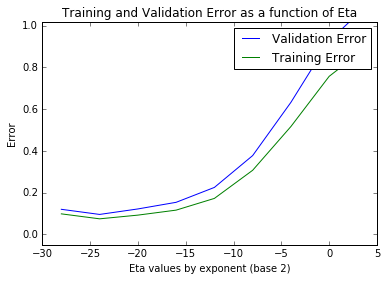

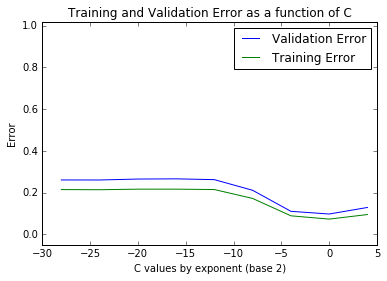

In [317]:
q6_a_plot_param_err(eta_values, np.array(train_err_eta), np.array(val_err_eta), param_name='Eta')
q6_a_plot_param_err(C_values, np.array(train_err_C), np.array(val_err_C), param_name='C')

## (b) plot the classifiers as images

In [163]:
def q6_b_plot_all_w(w):
    for j in range(len(w)):
        plt.figure()
        plt.title('classifier w for label '+str(j))
        plt.imshow(reshape(w[j],(28,28)), interpolation='nearest')
        plt.savefig('q6_b_classifier_w'+str(j)+'_figure.png')

In [ ]:
best_w = sgd_no_kernel(train_data, train_labels,eta = best_eta, C=best_C,T=100000)

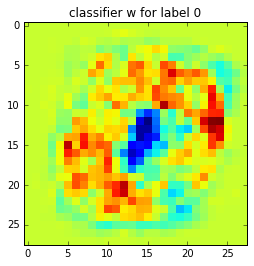

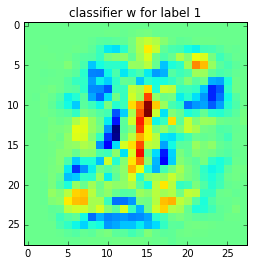

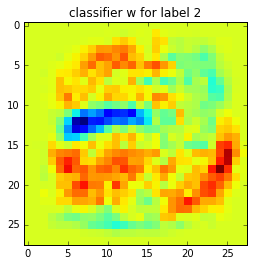

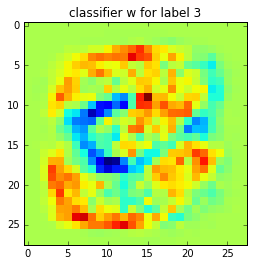

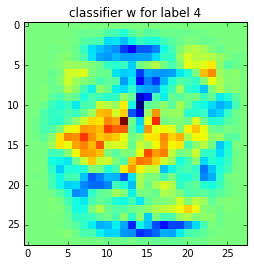

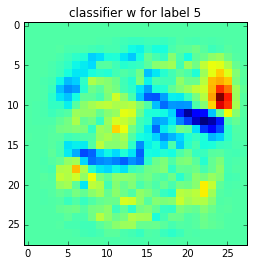

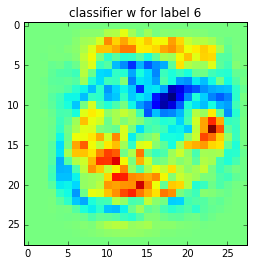

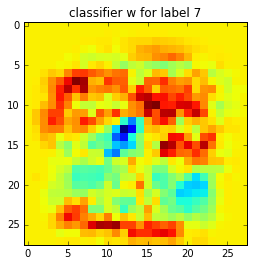

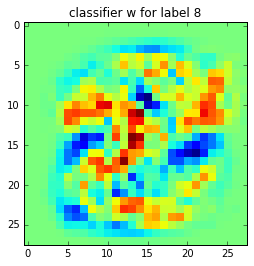

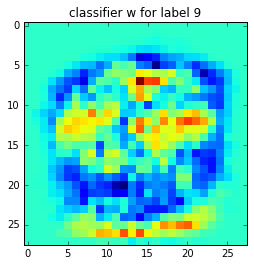

In [167]:
q6_b_plot_all_w(best_w)

### (c) Calculate the accuracy on the test set

In [136]:
def q6_c_acc_on_test(w, test_data, test_labels):
    return get_accuracy(w,test_data, test_labels)

In [168]:
q6_c_acc_on_test(best_w, test_data, test_labels)

0.9094

## Kernel Multiclass SVM

### (a) Implement the SGD_with_kernel version

In [296]:
def sgd_with_kernel(train_data, train_labels,T, eta = 0.1, C=1):
    '''implements SGD_no_kernel algorithm on training set and returns the W matrix'''
#     w= numpy.zeros(shape = (len(np.unique(train_labels)),train_data.shape[1])) # initiate weights vectors to zeros
    # initialize the S array for keeping the samples that made us update w
    S = {}
    for i in range(10): S[i] = []
        
    for t in range(T):
        ind = np.random.randint(len(train_data))# randomly pick one sample
        sample, sample_label= train_data[ind], train_labels[ind] 
        
        j_max = -9999999
        j_max_ind = 0
        for j in range(10): # find the maximal j value and index
            err = predict_given_S(S[j], C, eta,sample) - predict_given_S(S[sample_label], C, eta,sample) + int(sample_label != j)
            if j_max < err:
                j_max = err
                j_max_ind = j
        if j_max_ind != sample_label:
            S[j_max_ind].append((sample, T-t)) 
            S[sample_label].append((sample, T-t)) 
    return S  

In [297]:
def linear_kernel(x,y):
    return np.dot(x,y)

In [298]:
def quadratic_kernel(x,y, q=2):
    return pow(1+np.dot(x,y),q)

In [299]:
def predict_given_S(S, C, eta, new_sample, kernel = quadratic_kernel):
    ''' returns the prediction label'''
    best = -999999
    if len(S) == 0:
        return 0
    summ = 0.0
    for update_samples in reversed(S):
        if pow(1-eta,update_samples[1]) < 0.00001: # breaking condition
            break
        summ += kernel(update_samples[0], new_sample)*pow(1-eta,update_samples[1])
    pred = C*eta*summ
    return pred

In [300]:
def predict_with_kernel(S, C, eta, new_sample, kernel = quadratic_kernel):
    ''' returns the prediction label, based on the maximum wieght of w_j*x'''
    w = np.zeros(10)
    w_best_ind = 0
    best = -999999
    for j in range(len(w)):
        if len(S) == 0:
            print 'break because len(S) is 0'
            continue
        summ = 0.0
        for update_samples in reversed(S[j]):
            if pow(1-eta,update_samples[1]) < 0.00001:
                break
            summ += kernel(update_samples[0], new_sample)*pow(1-eta,update_samples[1])
        pred = C*eta*summ
        
        if pred >= best:
            w_best_ind = j
            best = pred
    return w_best_ind

In [301]:
def accuracy_with_kernel(validation_data, validation_labels, S,C,eta, kernel = quadratic_kernel):
    '''returns accuracy on the test data, given the classifier predictions'''
    err= 0
    for i in range(len(validation_data)):
        pred_ind = predict_with_kernel(S, C, eta, validation_data[i], kernel = kernel)
        if pred_ind != validation_labels[i]: # error in the prediction
            err = err+1
    return 1-1.0*err/len(validation_data)

In [302]:
def q7_a_grid_search(train_data, train_labels, validation_data, validation_labels, T=1000):
    eta_values = np.power(2.0,-1.0*np.arange(5,20,5))
    C_values = np.power(2.0,-1.0*np.arange(5,20,5))
    val_err_eta = []
    val_err_C = []
    for eta in eta_values:
        S_cur = sgd_with_kernel(train_data, train_labels, eta=eta, C=0.5,T=T)
        acc_val = accuracy_with_kernel(validation_data, validation_labels, S_cur, C=0.5, eta= eta)
        val_err_eta.append(1.0-acc_val)
        print 'eta :', eta, 'val_err: ',1.0-acc_val

    
    
    
    best_eta = list(eta_values)[val_err_eta.index(min(val_err_eta))]
    print 'q7_a: best eta', best_eta, ' with error ',min(val_err_eta) 
    S_list= []
    for C in C_values:
        S_cur = sgd_with_kernel(train_data, train_labels, eta=best_eta, C=C, T=T)
        S_list.append(S_cur)
        acc_val = accuracy_with_kernel(validation_data, validation_labels, S=S_cur, C=C, eta= best_eta)
        val_err_C.append(1.0-acc_val)
        print 'C :', C, 'val_err: ',1.0-acc_val
    best_C = list(C_values)[val_err_C.index(min(val_err_C))]
    best_S = S_list[val_err_C.index(min(val_err_C))]
    print 'q7_a: best C', best_C, 'with error ',min(val_err_C) 
    return best_eta, best_C, best_S, val_err_eta,val_err_C

### (b) accuracy on the test set

In [195]:
def q7_b_acc_test(test_data, test_labels,S,C,eta):
    return accuracy_with_kernel(test_data, test_labels,S,C,eta)

In [199]:
q7_b_acc_test(test_data, test_labels,best_S,best_C,best_eta)

0.11350000000000005